# 1 Author

**Student Name**:  Darrell Hoffman

**Student ID**:  210305771

# 2 Problem formulation

The goal of this analysis is to predict which of two songs is being hummed or whistled in an audio file: The Imperial March from Star Wars, and Hedwig's Theme from Harry Potter.

Audio recordings of each song from over one hundred different contributing students vary in tone, timing, or loudness of humming or whistling. However, there are certain patterns in rhythm and tone that could distinguish the songs. I decided to explore features from the audio that would capture variation in loudness throughout each recording as a proxy for rhythms, and features to capture frequency as a proxy for tones.

In this document I extract these 1-dimensional time series audio features to train a Long Short-Term Memory (LSTM - a type of Recurrent Neural Network) model and determine how accurately the trained model can predict which of the two songs is being hummed or whistled in a validation dataset.


# 3 Machine Learning pipeline

1. Data Preparation: Download the dataset and create dataframe linking song labels to audio files.
- Input: 824 audio WAV files containing student hum and whistle interpretations of Hedwig's Theme from Harry Potter or the Imperial March from Star Wars.
- Output: a files variable linking to all of the audio files and a dataframe linking song labels to audio files.

2. Transformations: Extract amplitude envelope, root mean squared energy, zero crossing rate, and short term fourier transform from each audio file and associated song label.
- Input: audio files, dataframe
- Transformations: extract audio signal and frame size > extract amplitude envelope (maximum energy for each frame), root mean squared energy, and zero crossing rate (the rate at which the signal crosses the horizontal axis - a simple proxy for frequency)
- Output: amplitude envelope, rms energy and zero crossing rate data for each file, True/False label for each file (True = Harry Potter, False = Star Wars).

3. Build LSTM model.

4. Train LSTM model with validation accuracy computed at each epoch.
- Input: training dataset audio features and labels, validation dataset audio features and labels
- Output: trained LSTM model with optimized validation accuracy

5. Evaluate model based on validation accuracy and confusion matrix.

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output.

In the transformation stage, I extracted the following features from each audio file: amplitude envelope - maximum power time series data; root mean squared energy - root mean squared power time series data; zero crossing rate - measure of dominant frequency in signal. Each feature was extracted from a frame of a certain length of time.

Amplitude envelope is a measure of the maximum power or loudness of the signal in each frame. I extracted this feature to try to capture any consistent patterns in loudness over time that differ between songs. This measure is sensitive to outliers because it takes into account only the maximum energy of all the samples in a frame.

Root mean squared energy is, as it sounds, the root mean squared energy of all the samples in a frame. It therefore less sensitive than amplitude envelope to outliers, but provided a second measure of loudness to approximate patterns in rhythm.

Zero crossing rate measures the number of times a signal (sine wave) crosses the horizontal axis. In otherwords, zero crossing rate is the rate at which the amplitude of a signal changes from positive to negative or from negative to positive.

From each audio file, I used the librosa library to extract an audio signal and sampling rate and used these as input into a series of functions to output the desired audio features. 

The output audio features defined above were output as list of all three features at each time frame and each list (representing one time frame) was combined in an array and used as input to the model described in the next section. A second array contained True/False labels for whether each audio file contained an interpretation of Hedwig's Theme from Harry Potter.

I learned to extract these features from the following video series: https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0

# 5 Modelling

Describe the ML models that you will implement.

I implemented a **Long short-term memory (LSTM)** model. LSTM is a type of recurrent neural network (RNN). RNNs contain loops that pass information from one step of the network to the next as a type of 'memory' that can inform what is being observed at one stage in a time series, based on what happened previously. LSTMs overcome a limitation of normal RNNs. LSTMs can 'remember' long-term dependencies that RNNs cannot.

LSTMs contain repeating modules of neural network in a chain. The repeating module contains four network layers that interact with a 'cell state' that moves through the chain with only minor linear interactions so information can pass along the cell state mostly unchanged. First, a sigmoid 'forget gate' layer outputs a value between 0 and 1 for each value in the cell state, based on the input and output from the module. A 1 means keep the value, 0 means forget the value. A second sigmoid 'input gate' layer determines which values to update and a tanh layer creates a vector of new possible values. These values are incorporated into the cell state before a final sigmoid 'output gate' layer determines which parts of the cell state to output and a tanh layer adjusts the values to between -1 and 1.

This functionality means LSTMs can selectively remember patterns over longer periods, making them adept at sequence prediction problems such as classifying these 1-dimensional time series features.

I learned about LSTMs and adapted code for my model from the following tutorials: https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

# 6 Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)

I shortened all of the time series data to match the length of the shortest sample in the dataset (54 frames). The model performed better with the shortened data compared with data padded to a maximum of 15 seconds.

I split the 3 dimensional by 54 frame array of audio features and the array of labels into training (70%) and validation (30%) sets. Both datasets were input to a LSTM model and run for 200 epochs. I used a sigmoid (finite range with logistic-like curve) initialization, the Adam algorithm as optimizer with a 0.001 learning rate, and a batch size of 32. Adam is a stochastic gradient descent method that is 'computationally efficient' (Kingma et al., 2014).

Validation accuracy was computed for each epoch and the model with the best validation accuracy was saved until the model could be improved further. I computed a confusion matrix from the final model to visualize where the model predictions did not match the validation labels.

# 7 Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

The dataset is extracted from a subset of the **Mile End Hums and Whistles dataset**, containing all of the available audio files for the Imperial March from Star Wars and Hedwig's Theme from Harry Potter. In this section I import necessary libraries for processing the data, download the data files, rename the files and create a dataframe linking the files to song name labels, and extract and visualize the audio features used to train the model in the following section.

**Importing Necessary libraries:**

In [ ]:
#importing libraries to prepare data and extract and visualize audio features
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import shutil

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


**Downloading zip files containing the audio files:**

In [ ]:
#define a function to download zip files containing audio files
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

In [ ]:
#download and save zip files
url  = "https://collect.qmul.ac.uk/down?t=6122TDAA73VPCMDQ/5DSHD27BLQMK5S8E1HLG19O"
save_path = '/content/drive/MyDrive/Data/MLENDHW/Potter_1.zip'
download_url(url, save_path)

In [ ]:
url_2  = "https://collect.qmul.ac.uk/down?t=4LV64IN5OK5E35NN/4H6DJTRS7KVD704UG2CN0IG"
save_path = '/content/drive/MyDrive/Data/MLENDHW/Potter_2.zip'
download_url(url_2, save_path)

In [ ]:
url_3  = "https://collect.qmul.ac.uk/down?t=650T7K3FAE26MB29/592IN2FALUM43SGC35O0580"
save_path = '/content/drive/MyDrive/Data/MLENDHW/StarWars_1.zip'
download_url(url_3, save_path)

In [ ]:
url_4  = "https://collect.qmul.ac.uk/down?t=6L5DHHRODAMK82R8/4512VDDUEFGBAPK0S82ENGO"
save_path = '/content/drive/MyDrive/Data/MLENDHW/StarWars_2.zip'
download_url(url_4, save_path)

**Extract audio files from zip files and save to new folders for each song. Declare files as list of file paths to original audio files:**

In [ ]:
#extract audio files from zip files
#Potter files t0 one folder
directory_to_extract_hp = '/content/drive/MyDrive/Data/MLENDHW/basic_1/Potter/'

zip_path = '/content/drive/MyDrive/Data/MLENDHW/Potter_1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_hp)

zip_path_2 = '/content/drive/MyDrive/Data/MLENDHW/Potter_2.zip'
with zipfile.ZipFile(zip_path_2, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_hp)

#StarWars files to second folder
directory_to_extract_sw = '/content/drive/MyDrive/Data/MLENDHW/basic_1/StarWars/'

zip_path_3 = '/content/drive/MyDrive/Data/MLENDHW/StarWars_1.zip'
with zipfile.ZipFile(zip_path_3, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_sw)

zip_path_4 = '/content/drive/MyDrive/Data/MLENDHW/StarWars_2.zip'
with zipfile.ZipFile(zip_path_4, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_sw)

#declare lists of file paths for all audio files
files_hp = glob.glob('/content/drive/MyDrive/Data/MLENDHW/basic_1/Potter/*.wav')
files_sw = glob.glob('/content/drive/MyDrive/Data/MLENDHW/basic_1/StarWars/*.wav')

**Rename and Re-declare file paths:**

I decided to rename all of the files to a consistent format containing only the participant ID, and the song name and attaching a unique file number to each audio file. 

In [ ]:
#RENAME POTTER FILES
for file_num in range(0, len(files_hp)):
    participant_ID = files_hp[file_num].split('/')[-1].split('_')[0]
    new_name = f"{'/'.join(files_hp[file_num].split('/')[:-1])}/{file_num}_{participant_ID}_Potter.wav"
    os.rename(files_hp[file_num], new_name)

#RENAME STARWARS FILES
for file_num in range(0, len(files_sw)):
    participant_ID = files_sw[file_num].split('/')[-1].split('_')[0]
    new_name = f"{'/'.join(files_sw[file_num].split('/')[:-1])}/{file_num}_{participant_ID}_Starwars.wav"
    os.rename(files_sw[file_num], new_name)

#re-declare lists of file paths for all audio files
files_hp = glob.glob('/content/drive/MyDrive/Data/MLENDHW/basic_1/Potter/*.wav')
files_sw = glob.glob('/content/drive/MyDrive/Data/MLENDHW/basic_1/StarWars/*.wav')

**Move all of the files to one folder and assign the path to all files as one variable:**

In [ ]:
#Move files to one folder
for file in files_hp:
    shutil.move(file, '/content/drive/MyDrive/Data/MLENDHW/basic_1')

for file in files_sw:
    shutil.move(file, '/content/drive/MyDrive/Data/MLENDHW/basic_1')

In [ ]:
#declare single list of file paths for all audio files
files = glob.glob('/content/drive/MyDrive/Data/MLENDHW/basic_1/*.wav')

**Visualize and listen to the first audio signal in the dataset:**

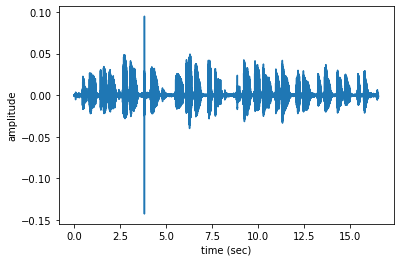

In [ ]:
n=0
fs = None
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

**Create a dataframe containing all of the file names, participant ID and the song name for each audio file in teh dataset:**

In [ ]:
#Create a data frame of file data
Potter_StarWars_table = [] 

for file in files:
  file_name = file.split('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[1]
  song = file.split('/')[-1].split('_')[-1].split('.')[0]
  Potter_StarWars_table.append([file_name,participant_ID,song])

Potter_StarWars_df = pd.DataFrame(Potter_StarWars_table,columns=['file_id','participant','song']).set_index('file_id') 
Potter_StarWars_df.head()

participant    song
file_id                            
0_S1_Potter.wav          S1  Potter
1_S1_Potter.wav          S1  Potter
2_S2_Potter.wav          S2  Potter
3_S2_Potter.wav          S2  Potter
4_S3_Potter.wav          S3  Potter

**Define a function to extract ampliltude envelope, root mean squared energy, zero crossing rate from an audio file:**

In [ ]:
#define function to extract time series audio features: ampliltude envelope, root mean squared energy, zero crossing rate
def extract_time_series_features(signal, frame_size, winLen=0.2):
  p = winLen*frame_size
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2  

  amplitude_envelope = [max(signal[i:i+frame_length]) for i in range(0, len(signal), hop_length)]
  rms_energy = librosa.feature.rms(signal, frame_length=frame_length, hop_length=hop_length).tolist()[0]
  zero_crossing_rate = librosa.feature.zero_crossing_rate(signal, frame_length=frame_length, hop_length=hop_length).tolist()[0]

  return amplitude_envelope, rms_energy, zero_crossing_rate

**Visualize the extracted audio features for each song:**

The two songs look similar in terms of the ratios between the three features. In observing the plotted features, the biggest clear difference is between the magnitude of the amplitude values between the hummed Harry Potter theme and the whistled Star Wars theme. It is difficult to distinguish any clear differences in pattern between the two songs.

In [ ]:
amplitude_envelope, rms_energy, zero_crossing_rate = extract_time_series_features(x, fs, winLen=0.2)

Harry Potter


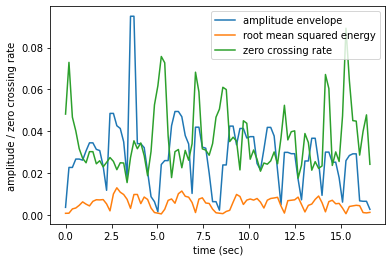

In [ ]:
print('Harry Potter')
t = np.linspace(0,len(x)/fs,len(amplitude_envelope))
plt.plot(t,amplitude_envelope,label='amplitude envelope')
plt.plot(t,rms_energy,label='root mean squared energy')
plt.plot(t,zero_crossing_rate,label='zero crossing rate')
plt.xlabel('time (sec)')
plt.ylabel('amplitude / zero crossing rate')
plt.legend()
plt.show()
display(ipd.Audio(files[n]))

In [ ]:
x, fs = librosa.load(files[-1],sr=fs)
amplitude_envelope, rms_energy, zero_crossing_rate = extract_time_series_features(x, fs, winLen=0.2)

Star Wars


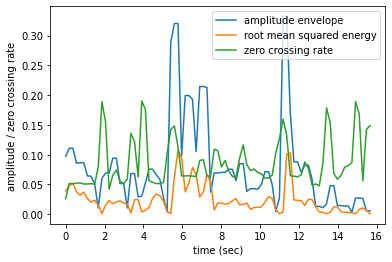

In [ ]:
print('Star Wars')
t = np.linspace(0,len(x)/fs,len(amplitude_envelope))
plt.plot(t,amplitude_envelope,label='amplitude envelope')
plt.plot(t,rms_energy,label='root mean squared energy')
plt.plot(t,zero_crossing_rate,label='zero crossing rate')
plt.xlabel('time (sec)')
plt.ylabel('amplitude / zero crossing rate')
plt.legend()
plt.show()
display(ipd.Audio(files[-1]))

**Define a function to return X and y values in a suitable format for input into the LSTM model. Run the function to obtain X containing time series data for amplitude envelope, root mean squared energy, and zero crossing rate, and y containing True/False labels indicating whether or not the song is from Harry Potter:**

In [ ]:
from itertools import chain, repeat, islice
#def pad_infinite(iterable, padding=None):
   #return chain(iterable, repeat(padding))

#def pad(iterable, size, padding=None):
   #return islice(pad_infinite(iterable, padding), size)

#define function to return arrays of audio features and song labels
def getXy(files, labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]

    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    
    xi = []

    amplitude_envelope, rms_energy, zero_crossing_rate = extract_time_series_features(x, fs, winLen=0.2)
    #amplitude_envelope = list(pad(amplitude_envelope,81,0))
    #rms_energy = list(pad(rms_energy,81,0))
    #zero_crossing_rate = list(pad(zero_crossing_rate,81,0))

    for frame in range(0,54):
      xi.append([amplitude_envelope[frame], rms_energy[frame], zero_crossing_rate[frame]])

    X.append(xi)
    y.append(yi)

  return np.array(X), np.array(y)

In [ ]:
X, y = getXy(files, labels_file=Potter_StarWars_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 824/824 [02:58<00:00,  4.61it/s]


# 8 Results

Carry out your experiments here, explain your results.

**Import Libraries needed to run the LSTM model and split data into training and validatioin sets:**

In [ ]:
#import libraries to split data and run the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import absl.logging

#split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 54, 3), (248, 54, 3), (576,), (248,))

**Create the Model:**

In [ ]:
#create a model
model = Sequential()
model.add(LSTM(256, input_shape=(54, 3)))
model.add(Dense(1, activation='sigmoid'))

**Set Model Parameters and Run the Model:**

In [ ]:
absl.logging.set_verbosity(absl.logging.ERROR)

adam = Adam(learning_rate=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=[chk], validation_data=(X_val, y_val))

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.6042
Epoch 00001: val_accuracy improved from -inf to 0.66129, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 11s 512ms/step - loss: 0.6740 - accuracy: 0.6042 - val_loss: 0.6604 - val_accuracy: 0.6613
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6267
Epoch 00002: val_accuracy did not improve from 0.66129
18/18 [==============================] - 3s 194ms/step - loss: 0.6689 - accuracy: 0.6267 - val_loss: 0.6722 - val_accuracy: 0.5605
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.5920
Epoch 00003: val_accuracy did not improve from 0.66129
18/18 [==============================] - 3s 193ms/step - loss: 0.6607 - accuracy: 0.5920 - val_loss: 0.6615 - val_accuracy: 0.5806
Epoch 4/200
18/18 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.6510
Epoch 00004: val_accuracy did not improve from 0.66129
18/18 [==============================] - 3s 189ms/step - loss: 0.6346 - accuracy: 0.6510 - val_loss: 0.6630 - val_accuracy: 0.6089
Epoch 5/200
18/18 [======

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 9s 522ms/step - loss: 0.6355 - accuracy: 0.6632 - val_loss: 0.6480 - val_accuracy: 0.6653
Epoch 6/200
18/18 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6649
Epoch 00006: val_accuracy did not improve from 0.66532
18/18 [==============================] - 4s 197ms/step - loss: 0.6290 - accuracy: 0.6649 - val_loss: 0.6430 - val_accuracy: 0.6653
Epoch 7/200
18/18 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.6701
Epoch 00007: val_accuracy improved from 0.66532 to 0.67742, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 477ms/step - loss: 0.6423 - accuracy: 0.6701 - val_loss: 0.6511 - val_accuracy: 0.6774
Epoch 8/200
18/18 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.7066
Epoch 00008: val_accuracy did not improve from 0.67742
18/18 [==============================] - 3s 190ms/step - loss: 0.6176 - accuracy: 0.7066 - val_loss: 0.6670 - val_accuracy: 0.6169
Epoch 9/200
18/18 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.6892
Epoch 00009: val_accuracy did not improve from 0.67742
18/18 [==============================] - 3s 189ms/step - loss: 0.6224 - accuracy: 0.6892 - val_loss: 0.6381 - val_accuracy: 0.6734
Epoch 10/200
18/18 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.6788
Epoch 00010: val_accuracy did not improve from 0.67742
18/18 [==============================] - 3s 191ms/step - loss: 0.6098 - accuracy: 0.6788 - val_loss: 0.6264 - val_accuracy: 0.6734
Epoch 11/200
18/18 [=====

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 479ms/step - loss: 0.5522 - accuracy: 0.7222 - val_loss: 0.5977 - val_accuracy: 0.6976
Epoch 19/200
18/18 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7274
Epoch 00019: val_accuracy did not improve from 0.69758
18/18 [==============================] - 3s 192ms/step - loss: 0.5421 - accuracy: 0.7274 - val_loss: 0.5879 - val_accuracy: 0.6815
Epoch 20/200
18/18 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.6944
Epoch 00020: val_accuracy did not improve from 0.69758
18/18 [==============================] - 3s 194ms/step - loss: 0.5782 - accuracy: 0.6944 - val_loss: 0.6047 - val_accuracy: 0.6815
Epoch 21/200
18/18 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7292
Epoch 00021: val_accuracy did not improve from 0.69758
18/18 [==============================] - 3s 194ms/step - loss: 0.5718 - accuracy: 0.7292 - val_loss: 0.6029 - val_accuracy: 0.6855
Epoch 22/200
18/18 [===

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 481ms/step - loss: 0.5335 - accuracy: 0.7361 - val_loss: 0.5696 - val_accuracy: 0.7097
Epoch 24/200
18/18 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7396
Epoch 00024: val_accuracy did not improve from 0.70968
18/18 [==============================] - 4s 197ms/step - loss: 0.5246 - accuracy: 0.7396 - val_loss: 0.5812 - val_accuracy: 0.6855
Epoch 25/200
18/18 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7465
Epoch 00025: val_accuracy did not improve from 0.70968
18/18 [==============================] - 4s 197ms/step - loss: 0.5152 - accuracy: 0.7465 - val_loss: 0.5554 - val_accuracy: 0.7016
Epoch 26/200
18/18 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7413
Epoch 00026: val_accuracy did not improve from 0.70968
18/18 [==============================] - 4s 201ms/step - loss: 0.5159 - accuracy: 0.7413 - val_loss: 0.5837 - val_accuracy: 0.6895
Epoch 27/200
18/18 [===

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 9s 543ms/step - loss: 0.5135 - accuracy: 0.7535 - val_loss: 0.5503 - val_accuracy: 0.7177
Epoch 28/200
18/18 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.7535
Epoch 00028: val_accuracy did not improve from 0.71774
18/18 [==============================] - 3s 193ms/step - loss: 0.4895 - accuracy: 0.7535 - val_loss: 0.5517 - val_accuracy: 0.7056
Epoch 29/200
18/18 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7413
Epoch 00029: val_accuracy improved from 0.71774 to 0.72984, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 486ms/step - loss: 0.4866 - accuracy: 0.7413 - val_loss: 0.5617 - val_accuracy: 0.7298
Epoch 30/200
18/18 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7431
Epoch 00030: val_accuracy did not improve from 0.72984
18/18 [==============================] - 3s 192ms/step - loss: 0.5246 - accuracy: 0.7431 - val_loss: 0.5369 - val_accuracy: 0.7056
Epoch 31/200
18/18 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.7257
Epoch 00031: val_accuracy did not improve from 0.72984
18/18 [==============================] - 3s 196ms/step - loss: 0.5183 - accuracy: 0.7257 - val_loss: 0.6006 - val_accuracy: 0.6895
Epoch 32/200
18/18 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.7326
Epoch 00032: val_accuracy did not improve from 0.72984
18/18 [==============================] - 3s 195ms/step - loss: 0.5093 - accuracy: 0.7326 - val_loss: 0.5555 - val_accuracy: 0.6935
Epoch 33/200
18/18 [===

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 488ms/step - loss: 0.4174 - accuracy: 0.7882 - val_loss: 0.5404 - val_accuracy: 0.7339
Epoch 50/200
18/18 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.7882
Epoch 00050: val_accuracy did not improve from 0.73387
18/18 [==============================] - 3s 195ms/step - loss: 0.4330 - accuracy: 0.7882 - val_loss: 0.5433 - val_accuracy: 0.7056
Epoch 51/200
18/18 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.7865
Epoch 00051: val_accuracy did not improve from 0.73387
18/18 [==============================] - 3s 195ms/step - loss: 0.4266 - accuracy: 0.7865 - val_loss: 0.5345 - val_accuracy: 0.7298
Epoch 52/200
18/18 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.7847
Epoch 00052: val_accuracy improved from 0.73387 to 0.73790, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 9s 537ms/step - loss: 0.4244 - accuracy: 0.7847 - val_loss: 0.5201 - val_accuracy: 0.7379
Epoch 53/200
18/18 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.7969
Epoch 00053: val_accuracy did not improve from 0.73790
18/18 [==============================] - 4s 199ms/step - loss: 0.4257 - accuracy: 0.7969 - val_loss: 0.5159 - val_accuracy: 0.7339
Epoch 54/200
18/18 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.7865
Epoch 00054: val_accuracy did not improve from 0.73790
18/18 [==============================] - 3s 195ms/step - loss: 0.4397 - accuracy: 0.7865 - val_loss: 0.5636 - val_accuracy: 0.7056
Epoch 55/200
18/18 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.7934
Epoch 00055: val_accuracy improved from 0.73790 to 0.74194, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 482ms/step - loss: 0.4209 - accuracy: 0.7934 - val_loss: 0.5211 - val_accuracy: 0.7419
Epoch 56/200
18/18 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.7951
Epoch 00056: val_accuracy did not improve from 0.74194
18/18 [==============================] - 3s 193ms/step - loss: 0.4075 - accuracy: 0.7951 - val_loss: 0.5021 - val_accuracy: 0.7258
Epoch 57/200
18/18 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8073
Epoch 00057: val_accuracy did not improve from 0.74194
18/18 [==============================] - 4s 197ms/step - loss: 0.4126 - accuracy: 0.8073 - val_loss: 0.5314 - val_accuracy: 0.7258
Epoch 58/200
18/18 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8108
Epoch 00058: val_accuracy improved from 0.74194 to 0.75806, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 9s 533ms/step - loss: 0.4175 - accuracy: 0.8108 - val_loss: 0.5174 - val_accuracy: 0.7581
Epoch 59/200
18/18 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8073
Epoch 00059: val_accuracy did not improve from 0.75806
18/18 [==============================] - 4s 201ms/step - loss: 0.4036 - accuracy: 0.8073 - val_loss: 0.5507 - val_accuracy: 0.7298
Epoch 60/200
18/18 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8038
Epoch 00060: val_accuracy did not improve from 0.75806
18/18 [==============================] - 4s 196ms/step - loss: 0.3984 - accuracy: 0.8038 - val_loss: 0.5213 - val_accuracy: 0.7460
Epoch 61/200
18/18 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.7882
Epoch 00061: val_accuracy did not improve from 0.75806
18/18 [==============================] - 4s 198ms/step - loss: 0.4284 - accuracy: 0.7882 - val_loss: 0.5798 - val_accuracy: 0.6976
Epoch 62/200
18/18 [===

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 490ms/step - loss: 0.3632 - accuracy: 0.8316 - val_loss: 0.5177 - val_accuracy: 0.7742
Epoch 70/200
18/18 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8073
Epoch 00070: val_accuracy did not improve from 0.77419
18/18 [==============================] - 4s 196ms/step - loss: 0.3893 - accuracy: 0.8073 - val_loss: 0.5109 - val_accuracy: 0.7339
Epoch 71/200
18/18 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8177
Epoch 00071: val_accuracy did not improve from 0.77419
18/18 [==============================] - 3s 195ms/step - loss: 0.3996 - accuracy: 0.8177 - val_loss: 0.5163 - val_accuracy: 0.7661
Epoch 72/200
18/18 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8125
Epoch 00072: val_accuracy improved from 0.77419 to 0.78629, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 479ms/step - loss: 0.4097 - accuracy: 0.8125 - val_loss: 0.4627 - val_accuracy: 0.7863
Epoch 73/200
18/18 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8090
Epoch 00073: val_accuracy did not improve from 0.78629
18/18 [==============================] - 3s 195ms/step - loss: 0.3932 - accuracy: 0.8090 - val_loss: 0.5053 - val_accuracy: 0.7500
Epoch 74/200
18/18 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8229
Epoch 00074: val_accuracy improved from 0.78629 to 0.79032, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 478ms/step - loss: 0.3776 - accuracy: 0.8229 - val_loss: 0.4903 - val_accuracy: 0.7903
Epoch 75/200
18/18 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8229
Epoch 00075: val_accuracy did not improve from 0.79032
18/18 [==============================] - 4s 198ms/step - loss: 0.3594 - accuracy: 0.8229 - val_loss: 0.5080 - val_accuracy: 0.7460
Epoch 76/200
18/18 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.8438
Epoch 00076: val_accuracy improved from 0.79032 to 0.79839, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 9s 543ms/step - loss: 0.3477 - accuracy: 0.8438 - val_loss: 0.4660 - val_accuracy: 0.7984
Epoch 77/200
18/18 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8438
Epoch 00077: val_accuracy did not improve from 0.79839
18/18 [==============================] - 3s 194ms/step - loss: 0.3406 - accuracy: 0.8438 - val_loss: 0.5155 - val_accuracy: 0.7863
Epoch 78/200
18/18 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8299
Epoch 00078: val_accuracy improved from 0.79839 to 0.81452, saving model to best_model.pkl
INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 487ms/step - loss: 0.3399 - accuracy: 0.8299 - val_loss: 0.4670 - val_accuracy: 0.8145
Epoch 79/200
18/18 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8576
Epoch 00079: val_accuracy did not improve from 0.81452
18/18 [==============================] - 4s 204ms/step - loss: 0.3174 - accuracy: 0.8576 - val_loss: 0.5296 - val_accuracy: 0.7702
Epoch 80/200
18/18 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8628
Epoch 00080: val_accuracy did not improve from 0.81452
18/18 [==============================] - 4s 207ms/step - loss: 0.3131 - accuracy: 0.8628 - val_loss: 0.5104 - val_accuracy: 0.7903
Epoch 81/200
18/18 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8438
Epoch 00081: val_accuracy did not improve from 0.81452
18/18 [==============================] - 4s 207ms/step - loss: 0.3293 - accuracy: 0.8438 - val_loss: 0.5800 - val_accuracy: 0.7742
Epoch 82/200
18/18 [===

INFO:tensorflow:Assets written to: best_model.pkl/assets


18/18 [==============================] - 8s 489ms/step - loss: 0.3031 - accuracy: 0.8472 - val_loss: 0.5697 - val_accuracy: 0.8266
Epoch 93/200
18/18 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.8611
Epoch 00093: val_accuracy did not improve from 0.82661
18/18 [==============================] - 4s 206ms/step - loss: 0.2985 - accuracy: 0.8611 - val_loss: 0.5033 - val_accuracy: 0.7984
Epoch 94/200
18/18 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.8767
Epoch 00094: val_accuracy did not improve from 0.82661
18/18 [==============================] - 4s 206ms/step - loss: 0.2778 - accuracy: 0.8767 - val_loss: 0.5283 - val_accuracy: 0.7984
Epoch 95/200
18/18 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8837
Epoch 00095: val_accuracy did not improve from 0.82661
18/18 [==============================] - 4s 238ms/step - loss: 0.2734 - accuracy: 0.8837 - val_loss: 0.5323 - val_accuracy: 0.7984
Epoch 96/200
18/18 [===

**Load the model and comput metrics of model success: precision, recall, accuracy and confusion matrix:**

In [ ]:
model = load_model('best_model.pkl')
val_preds = model.predict(X_val).round(0).astype(bool)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

precision, recall, _, _ = precision_recall_fscore_support(y_val, val_preds)
print('Precision for each class: {0}.'.format(precision))
print('Recall for each class: {0}.\n'.format(recall))

matrix = confusion_matrix(y_val, val_preds)

df = pd.DataFrame.from_records(matrix)
print('Confusion matrix:')
display(df)

Precision for each class: [0.83478261 0.81954887].
Recall for each class: [0.8       0.8515625].

Confusion matrix:


0    1
0  96   24
1  19  109

A:
[0.8       0.8515625]


The training accuracy of the best model was 84.7% and the validation accuracy was 82.7%. 

Precision for predicting Hedwig's Theme was 83.5%, and precision for predicting The Imperial March was 82.0%. In other words, 96 of the 115 samples in the validation dataset were classified as Hedwig's Theme, were in fact Hedwig's Theme, and 109 of the 133 samples classified as Imperial March were in fact Imperial March. 

Recall for predicting Hedwig's Theme was 80.0%, and recall for predicting The Imperial March was 85.2%. In other words, 96 of the 120 Hedwig's Theme samples in the validation dataset were correctly classified and 109 of the 128 Imperial March samples were correctly classified.

**The results are present in the figure below. A positive result indicates Hedwig's Theme and a negative result indicates the Imperial March:**

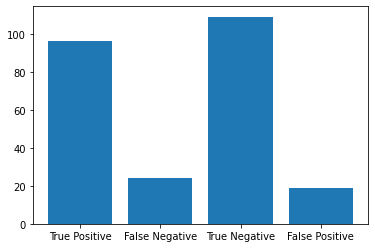

In [ ]:
x = ['True Positive', 'False Negative', 'True Negative', 'False Positive']
y = [96,24,109,19]

plt.bar(x,y)
plt.show()

# 9 Conclusions

Training an LSTM model to classify songs based on amplitude envelope, root mean squared energy, and zero crossing rate resulted in a training accuracy of 84.7% and a validation accuracy of 82.7%, meaning the model is not greatly overfitting to the training data and the majority of samples are being correctly classified. The validation accuracy was slightly lower (80.0%) for the Harry Potter samples than for the Star Wars samples (85.2%).

The root mean squared energy appeared to be the most important audio feature for the success of the model, running the model with just amplitude envelope and zero crossing rate resulted in the lowest validation accuracy. Removing the amplitude envelope from the input data had a much smaller impact on the result (validation accuracy of 80% for that run). After experimenting with model parameters, the only improvement in the accuracy results came from reducing the batch size from 128 to 32, giving a 5% increase in validation accuracy.

The extracted audio features as input to an LSTM seem to have produced a fairly good resulting model. Some potential improvements that could be explored are: dividing the humming and whistling files before extracting features, experimenting with the number of frames extracted for each feature, smoothing the data such as with a rolling average (I tried this but it did not improve the results), and further experimentation with the model hyperparameters.
